# Add new column to hosted feature service
With this notebook, we will add the column *alternative_names* to the feature layer containing countries' precalculated data `https://eowilson.maps.arcgis.com/home/item.html?id=f11bd71ecc4c47aab7735b3cf3e21392`

## Table of contents
1. [First steps](#first)
    1. [Import packages](#packages)
    2. [Connect to ESRI](#esri)
    3. [Utils](#utils)
2. [Clone service](#clone) 
3. [Import layer as dataframe](#dataframe)
4. [Create new field](#field)
5. [Update hosted layer](#update)

<a id='first'></a>
## First steps

<a id='packages'></a>
### Import packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
from copy import deepcopy
import os

<a id='esri'></a>
### Connect to ESRI

In [2]:
env_path = ".env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

In [3]:
aol_password = env['ARCGIS_GRETA_PASS']
aol_username = env['ARCGIS_GRETA_USER']

In [11]:
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")

Keyring backend being used (keyring.backends.OS_X.Keyring (priority: 5)) either failed to install or is not recommended by the keyring project (i.e. it is not secure). This means you can not use stored passwords through GIS's persistent profiles. Note that extra system-wide steps must be taken on a Linux machine to use the python keyring module securely. Read more about this at the keyring API doc (http://bit.ly/2EWDP7B) and the ArcGIS API for Python doc (http://bit.ly/2CK2wG8).


<a id='utils'></a>
### Utils

In [4]:
# To convert an existing hosted layer in an spatial dataframe
def getHTfromId(item_id):
    item = gis.content.get(item_id)
    flayer = item.layers[0]
    sdf = flayer.query().sdf
    return sdf

In [6]:
### To create new field(s) in a hosted service
def createFieldsToBeAdded(flayer, csv_table):
    flayer_fields = flayer.manager.properties.fields
    template_field = dict(deepcopy(flayer_fields[0]))
    sdf = sdf = flayer.query().sdf
    new_field_names = list(csv_table.columns.difference(sdf.columns))
    
    fields_to_be_added = []
    for new_field_name in new_field_names:
        current_field = deepcopy(template_field)
        dt = csv_table[new_field_name].dtypes
        
        if dt == 'O':
            #put the type to character
            current_field['sqlType'] = 'sqlTypeOther'
            current_field['type'] = 'esriFieldTypeString'
            current_field['length'] = 45000
        if dt == 'int64':
            #put the type to double
            current_field['sqlType'] = 'sqlTypeOther'
            current_field['type'] = 'esriFieldTypeDouble'
            #current_field['length'] = 8000      

        current_field['name'] = new_field_name.lower()
        current_field['alias'] = new_field_name
        current_field['nullable'] = True
        current_field['editable'] = True
        fields_to_be_added.append(current_field)
    return fields_to_be_added

In [22]:
# To identify features to be updated. See https://developers.arcgis.com/python/sample-notebooks/updating-features-in-a-feature-layer/ for reference
def createFeaturesForUpdate(flayer, csv_table, fields_to_be_added, id_field_in_csv, id_field_in_service):
    fset2 = flayer.query()
    features2 = fset2.features
    features_for_update = []
    for country_id in csv_table[id_field_in_csv]:
        try:
            # get the matching row from csv
            matching_row = csv_table.where(csv_table[id_field_in_csv] == country_id).dropna()

            #print(str(country_id) + " Adding additional attributes for: " + matching_row['iso3'].values[0])

            # get the feature to be updated
            assert  len([f for f in features2 if f.attributes[id_field_in_service] == country_id]),  "id not matched"
            original_feature = [f for f in features2 if f.attributes[id_field_in_service] == country_id][0]
            feature_to_be_updated = deepcopy(original_feature)

            # assign the updated values
            for field in fields_to_be_added:
                feature_to_be_updated.attributes[field['name']] = matching_row[field['name']].values[0]
                #add this to the list of features to be updated
                features_for_update.append(feature_to_be_updated)
    
        except:
            print(f"{country_id} not available in service")
    return features_for_update

------
<a id='clone'></a>
### Clone service: create a duplicate from the gadm0 layer to test changes
Before updating any layers used in production, it is a good practice to test the notebook using a cloned dataset. In this case, we are going to clone gadm0_precalculated and add a new field called *alternative_names*. Once we are sure it works, we can run the notebook using the ID or the production layer (and delete the cloned dataset)

<Item title:"gadm0_precalculated_20220224" type:Feature Layer Collection owner:greta.carrete_eowilson>
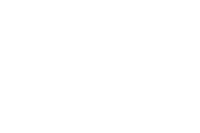

In [5]:
# gadm = gis.content.get("f11bd71ecc4c47aab7735b3cf3e21392")
# gadm

In [6]:
# cloning_list = [gadm]
# cloning_list

[<Item title:"gadm0_precalculated_20220224" type:Feature Layer Collection owner:greta.carrete_eowilson>]

In [8]:
# # Clone items (staging and production tables)
# cloned_gadm = gis.content.clone_items(items=cloning_list)

--------
<a id='dataframe'></a>
### Import layer to manipulate it as a dataframe

In [12]:
# Bring the desired layer as a dataframe
gadm0 = getHTfromId('f11bd71ecc4c47aab7735b3cf3e21392') #id of the hosted service (or the cloned service) we want to modify
gadm0.head(5)

,GID_0,NAME_0,MOL_ID,AREA_KM2,amphibians,birds,mammals,reptiles,percentage_protected,population_sum,...,climate_regime_majority,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,country_size,ObjectId,Shape__Area,Shape__Length,SHAPE
0,ABW,Aruba,1,1.819384e+02,"[{""SliceNumber"":1819,""per_global"":0.6,""per_aoi...","[{""SliceNumber"":142,""per_global"":0.0,""per_aoi""...","[{""SliceNumber"":329,""per_global"":0.0,""per_aoi""...","[{""SliceNumber"":353,""per_global"":0.01,""per_aoi...",20.609300,115656.10,...,Tropical Dry,None,24.66,None,6.39,5,1,1.922450e+08,7.239827e+04,"{""rings"": [[[-7789937.05527832, 1399228.874996..."
1,AFG,Afghanistan,2,6.438575e+05,"[{""SliceNumber"":32,""per_global"":100.0,""per_aoi...","[{""SliceNumber"":26,""per_global"":1.44,""per_aoi""...","[{""SliceNumber"":167,""per_global"":11.15,""per_ao...","[{""SliceNumber"":1,""per_global"":28.71,""per_aoi""...",3.785337,30389700.00,...,Cool Temperate Dry,6.48,18.49,62.15,0.07,3,2,9.372460e+11,6.715507e+06,"{""rings"": [[[7628327.94472602, 3731107.8519135..."
2,AGO,Angola,3,1.247422e+06,"[{""SliceNumber"":2,""per_global"":0.59,""per_aoi"":...","[{""SliceNumber"":26,""per_global"":4.67,""per_aoi""...","[{""SliceNumber"":28,""per_global"":2.22,""per_aoi""...","[{""SliceNumber"":40,""per_global"":26.68,""per_aoi...",6.679349,36074940.00,...,Sub Tropical Moist,0.07,4.19,67.89,0.08,2,3,1.318872e+12,7.381993e+06,"{""rings"": [[[1306164.11380903, -1882741.235359..."
3,AIA,Anguilla,4,8.330331e+01,"[{""SliceNumber"":1819,""per_global"":0.23,""per_ao...","[{""SliceNumber"":142,""per_global"":0.0,""per_aoi""...","[{""SliceNumber"":329,""per_global"":0.0,""per_aoi""...","[{""SliceNumber"":316,""per_global"":25.32,""per_ao...",2.880000,13601.96,...,Tropical Moist,None,NaN,None,NaN,5,4,9.309974e+07,9.508751e+04,"{""rings"": [[[-7060299.75801276, 2106609.789138..."
4,ALA,Åland,5,1.506261e+03,"[{""SliceNumber"":963,""per_global"":0.01,""per_aoi...","[{""SliceNumber"":116,""per_global"":0.01,""per_aoi...","[{""SliceNumber"":129,""per_global"":0.01,""per_aoi...","[{""SliceNumber"":2500,""per_global"":0.01,""per_ao...",1.449518,29158.96,...,Cool Temperate Moist,None,50.27,None,NaN,5,5,5.720699e+09,4.686757e+06,"{""rings"": [[[2373548.29389075, 8344256.0518993..."


<a id='field'></a>
### Create new field in dataframe

In [14]:
# Create a new field with no values
NaN = np.nan
gadm0["alternative_names"] = NaN

In [15]:
# Add alternative names for those countries that are known by their abbreviations or by different names
gadm0.loc[gadm0.NAME_0 == "United Kingdom", "alternative_names"] = "UK"
gadm0.loc[gadm0.NAME_0 == "United States", "alternative_names"] = "US, United States of America, USA"
gadm0.loc[gadm0.NAME_0 == "Swaziland", "alternative_names"] = "Eswatini"
gadm0.loc[gadm0.NAME_0 == "Timor-Leste", "alternative_names"] = "East Timor"
gadm0.loc[gadm0.NAME_0 == "North Macedonia", "alternative_names"] = "Republic of Macedonia"
gadm0.loc[gadm0.NAME_0 == "Czechia", "alternative_names"] = "Czech Republic"
gadm0.loc[gadm0.NAME_0 == "Côte d'Ivoire", "alternative_names"] = "Ivory Coast"
gadm0.loc[gadm0.NAME_0 == "Turkey", "alternative_names"] = "Türkiye"
gadm0.loc[gadm0.NAME_0 == "Myanmar", "alternative_names"] = "Burma"
gadm0.loc[gadm0.NAME_0 == "Cabo Verde", "alternative_names"] = "Cape Verde"

In [16]:
gadm0[gadm0.alternative_names.notnull()]

,GID_0,NAME_0,MOL_ID,AREA_KM2,amphibians,birds,mammals,reptiles,percentage_protected,population_sum,...,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,country_size,ObjectId,Shape__Area,Shape__Length,SHAPE,alternative_names
44,CIV,Côte d'Ivoire,45,321658.100,"[{""SliceNumber"":1,""per_global"":100.0,""per_aoi""...","[{""SliceNumber"":26,""per_global"":1.33,""per_aoi""...","[{""SliceNumber"":126,""per_global"":13.11,""per_ao...","[{""SliceNumber"":58,""per_global"":0.02,""per_aoi""...",22.245140,26505780.0,...,0.15,49.42,47.36,0.21,4,45,3.297613e+11,3.644301e+06,"{""rings"": [[[-742423.513009593, 527093.8477063...",Ivory Coast
51,CPV,Cabo Verde,52,4090.953,"[{""SliceNumber"":252,""per_global"":0.05,""per_aoi...","[{""SliceNumber"":102,""per_global"":98.58,""per_ao...","[{""SliceNumber"":2335,""per_global"":0.04,""per_ao...","[{""SliceNumber"":2171,""per_global"":96.43,""per_a...",3.010442,531217.4,...,None,10.42,None,NaN,5,52,4.470298e+09,9.857686e+05,"{""rings"": [[[-2748122.64314274, 1667617.007130...",Cape Verde
58,CZE,Czechia,59,78835.730,"[{""SliceNumber"":815,""per_global"":2.47,""per_aoi...","[{""SliceNumber"":42,""per_global"":0.22,""per_aoi""...","[{""SliceNumber"":129,""per_global"":0.18,""per_aoi...","[{""SliceNumber"":573,""per_global"":0.2,""per_aoi""...",22.839670,10840560.0,...,0.87,85.86,0,2.67,5,59,1.886033e+11,3.044001e+06,"{""rings"": [[[1628698.85982985, 6208557.2578413...",Czech Republic
79,GBR,United Kingdom,80,245485.800,"[{""SliceNumber"":155,""per_global"":0.0,""per_aoi""...","[{""SliceNumber"":42,""per_global"":0.44,""per_aoi""...","[{""SliceNumber"":259,""per_global"":1.34,""per_aoi...","[{""SliceNumber"":574,""per_global"":9.59,""per_aoi...",27.395490,67286180.0,...,None,52.96,37.23,7.20,3,80,7.178775e+11,2.937811e+07,"{""rings"": [[[-711099.45954443, 6423576.8673716...",UK
144,MKD,North Macedonia,145,24825.140,"[{""SliceNumber"":819,""per_global"":2.19,""per_aoi...","[{""SliceNumber"":29,""per_global"":0.32,""per_aoi""...","[{""SliceNumber"":253,""per_global"":0.22,""per_aoi...","[{""SliceNumber"":7,""per_global"":0.92,""per_aoi"":...",8.061651,2098622.0,...,8.66,53.60,9.65,1.39,5,145,4.443545e+10,9.815638e+05,"{""rings"": [[[2532459.60096151, 5039310.5724504...",Republic of Macedonia
147,MMR,Myanmar,148,669296.900,"[{""SliceNumber"":265,""per_global"":100.0,""per_ao...","[{""SliceNumber"":2,""per_global"":16.61,""per_aoi""...","[{""SliceNumber"":83,""per_global"":22.14,""per_aoi...","[{""SliceNumber"":99,""per_global"":4.32,""per_aoi""...",6.825683,48315930.0,...,1.09,25.26,0.31,1.88,3,148,7.760832e+11,2.220841e+07,"{""rings"": [[[10886951.4177547, 986896.90396842...",Burma
211,SWZ,Swaziland,212,17383.030,"[{""SliceNumber"":33,""per_global"":8.47,""per_aoi""...","[{""SliceNumber"":26,""per_global"":0.08,""per_aoi""...","[{""SliceNumber"":28,""per_global"":0.21,""per_aoi""...","[{""SliceNumber"":40,""per_global"":0.21,""per_aoi""...",4.358740,1097640.0,...,6.14,3.09,84.38,1.50,5,212,2.181136e+10,6.144976e+05,"{""rings"": [[[3512795.70073153, -3162959.035343...",Eswatini
222,TLS,Timor-Leste,223,14915.480,"[{""SliceNumber"":1993,""per_global"":1.65,""per_ao...","[{""SliceNumber"":40,""per_global"":0.36,""per_aoi""...","[{""SliceNumber"":27,""per_global"":19.7,""per_aoi""...","[{""SliceNumber"":143,""per_global"":0.01,""per_aoi...",16.340150,1396039.0,...,None,23.78,0.22,9.86,5,223,1.539389e+10,9.689011e+05,"{""rings"": [[[13912488.6650894, -1032250.424257...",East Timor
226,TUR,Turkey,227,780704.600,"[{""SliceNumber"":819,""per_global"":0.28,""per_aoi...","[{""SliceNumber"":29,""per_global"":5.34,""per_aoi""...","[{""SliceNumber"":31,""per_global"":99.06,""per_aoi...","[{""SliceNumber"":1,""per_global"":4.66,""per_aoi"":...",0.205484,80240490.0,...,8.29,67.78,10.94,1.28,3,227,1.298121e+12,1.231097e+07,"{""rings"": [[[3268943.32077577, 4330686.0815848...",Türkiye
234,USA,United States,235,9472976.000,"[{""SliceNumber"":3,""per_global"":97.49,""per_aoi""...","[{""SliceNumber"":36,""per

<a id='update'></a>
### Update hosted layer

In [17]:
# Call service to be updated and compare it with the sdf we have modified to identify field(s) to be added
item = gis.content.get('f11bd71ecc4c47aab7735b3cf3e21392') #id of layer to update (original or cloned)
flayer = item.layers[0]
fields_to_be_added = createFieldsToBeAdded(flayer, gadm0) 
fields_to_be_added # This is the field(s) that is different between the new df and hosted layer

[{'name': 'alternative_names',
  'type': 'esriFieldTypeString',
  'actualType': 'nvarchar',
  'alias': 'alternative_names',
  'sqlType': 'sqlTypeOther',
  'length': 45000,
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None}]

In [19]:
# Add the new column (empty) in the hosted service
flayer.manager.add_to_definition({'fields':fields_to_be_added})

{'success': True}

In [23]:
# Identify differences between the field we just created in the hosted service and the column with values in the modified sdf
features_for_update = createFeaturesForUpdate(flayer = flayer ,
                        csv_table = gadm0,
                        fields_to_be_added =  fields_to_be_added, 
                        id_field_in_csv = "MOL_ID", 
                        id_field_in_service = "MOL_ID")

1 not available in service
2 not available in service
3 not available in service
4 not available in service
5 not available in service
6 not available in service
7 not available in service
8 not available in service
9 not available in service
10 not available in service
11 not available in service
12 not available in service
13 not available in service
14 not available in service
15 not available in service
16 not available in service
17 not available in service
18 not available in service
19 not available in service
20 not available in service
21 not available in service
22 not available in service
23 not available in service
24 not available in service
25 not available in service
26 not available in service
27 not available in service
28 not available in service
29 not available in service
30 not available in service
31 not available in service
32 not available in service
33 not available in service
34 not available in service
35 not available in service
36 not available in service
3

In [24]:
# Add the values to the hosted service
flayer.edit_features(updates= features_for_update)

{'addResults': [],
 'updateResults': [{'objectId': 45,
   'uniqueId': 45,
   'globalId': None,
   'success': True},
  {'objectId': 59, 'uniqueId': 59, 'globalId': None, 'success': True},
  {'objectId': 145, 'uniqueId': 145, 'globalId': None, 'success': True},
  {'objectId': 148, 'uniqueId': 148, 'globalId': None, 'success': True},
  {'objectId': 212, 'uniqueId': 212, 'globalId': None, 'success': True},
  {'objectId': 227, 'uniqueId': 227, 'globalId': None, 'success': True},
  {'objectId': 235, 'uniqueId': 235, 'globalId': None, 'success': True}],
 'deleteResults': []}

In [25]:
# Check updated dataframe
gadm_updated = getHTfromId('f11bd71ecc4c47aab7735b3cf3e21392') 
gadm_updated[gadm_updated.alternative_names.notnull()]

,GID_0,NAME_0,MOL_ID,AREA_KM2,amphibians,birds,mammals,reptiles,percentage_protected,population_sum,...,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,country_size,ObjectId,Shape__Area,Shape__Length,alternative_names,SHAPE
44,CIV,Côte d'Ivoire,45,321658.10,"[{""SliceNumber"":1,""per_global"":100.0,""per_aoi""...","[{""SliceNumber"":26,""per_global"":1.33,""per_aoi""...","[{""SliceNumber"":126,""per_global"":13.11,""per_ao...","[{""SliceNumber"":58,""per_global"":0.02,""per_aoi""...",22.245140,26505780.0,...,0.15,49.42,47.36,0.21,4,45,3.297613e+11,3.644301e+06,Ivory Coast,"{""rings"": [[[-742423.513009593, 527093.8477063..."
58,CZE,Czechia,59,78835.73,"[{""SliceNumber"":815,""per_global"":2.47,""per_aoi...","[{""SliceNumber"":42,""per_global"":0.22,""per_aoi""...","[{""SliceNumber"":129,""per_global"":0.18,""per_aoi...","[{""SliceNumber"":573,""per_global"":0.2,""per_aoi""...",22.839670,10840560.0,...,0.87,85.86,0,2.67,5,59,1.886033e+11,3.044001e+06,Czech Republic,"{""rings"": [[[1628698.85982985, 6208557.2578413..."
144,MKD,North Macedonia,145,24825.14,"[{""SliceNumber"":819,""per_global"":2.19,""per_aoi...","[{""SliceNumber"":29,""per_global"":0.32,""per_aoi""...","[{""SliceNumber"":253,""per_global"":0.22,""per_aoi...","[{""SliceNumber"":7,""per_global"":0.92,""per_aoi"":...",8.061651,2098622.0,...,8.66,53.60,9.65,1.39,5,145,4.443545e+10,9.815638e+05,Republic of Macedonia,"{""rings"": [[[2532459.60096151, 5039310.5724504..."
147,MMR,Myanmar,148,669296.90,"[{""SliceNumber"":265,""per_global"":100.0,""per_ao...","[{""SliceNumber"":2,""per_global"":16.61,""per_aoi""...","[{""SliceNumber"":83,""per_global"":22.14,""per_aoi...","[{""SliceNumber"":99,""per_global"":4.32,""per_aoi""...",6.825683,48315930.0,...,1.09,25.26,0.31,1.88,3,148,7.760832e+11,2.220841e+07,Burma,"{""rings"": [[[10886951.4177547, 986896.90396842..."
211,SWZ,Swaziland,212,17383.03,"[{""SliceNumber"":33,""per_global"":8.47,""per_aoi""...","[{""SliceNumber"":26,""per_global"":0.08,""per_aoi""...","[{""SliceNumber"":28,""per_global"":0.21,""per_aoi""...","[{""SliceNumber"":40,""per_global"":0.21,""per_aoi""...",4.358740,1097640.0,...,6.14,3.09,84.38,1.50,5,212,2.181136e+10,6.144976e+05,Eswatini,"{""rings"": [[[3512795.70073153, -3162959.035343..."
226,TUR,Turkey,227,780704.60,"[{""SliceNumber"":819,""per_global"":0.28,""per_aoi...","[{""SliceNumber"":29,""per_global"":5.34,""per_aoi""...","[{""SliceNumber"":31,""per_global"":99.06,""per_aoi...","[{""SliceNumber"":1,""per_global"":4.66,""per_aoi"":...",0.205484,80240490.0,...,8.29,67.78,10.94,1.28,3,227,1.298121e+12,1.231097e+07,Türkiye,"{""rings"": [[[3268943.32077577, 4330686.0815848..."
234,USA,United States,235,9472976.00,"[{""SliceNumber"":3,""per_global"":97.49,""per_aoi""...","[{""SliceNumber"":36,""per_global"":71.9,""per_aoi""...","[{""SliceNumber"":129,""per_global"":7.89,""per_aoi...","[{""SliceNumber"":145,""per_global"":93.71,""per_ao...",16.069110,342629300.0,...,0.85,26.35,20.6,4.37,1,235,2.172306e+13,9.831533e+07,"US, United States of America, USA","{""rings"": [[[-17813472.3754415, -44311.6305776..."


In [26]:
id_new = gadm_updated.MOL_ID[gadm_updated.alternative_names.notnull()]
id_old = gadm0.MOL_ID[gadm0.alternative_names.notnull()]

In [31]:
missing = id_old[~id_old.isin(id_new)]

In [32]:
gadm_updated.NAME_0[gadm_updated.MOL_ID.isin(missing)]

51         Cabo Verde
79     United Kingdom
222       Timor-Leste
Name: NAME_0, dtype: object

In [34]:
gadm0.alternative_names[gadm0.MOL_ID.isin(missing)]

51     Cape Verde
79             UK
222    East Timor
Name: alternative_names, dtype: object

---
#### Now the hosted layer or table has a new column populated with the new values BUT, for some reason, it only updates 7 out of 10 countries. Let's add the remaining names manually in AGOL: Cabo Verde (Cape Verde), United Kingdom (UK), Timor-Leste (East Timor)
---